In [1]:
import json
import pandas as pd
import numpy as np
import opendatasets as od
import seaborn as sns

import matplotlib.pyplot as plt

from utils.attributes import TARGET_COLUMN, SENSITIVE_ATTRIBUTES, NOT_FEATURES, SALARY_MAPPING

DATASET_URL = 'https://www.kaggle.com/datasets/datahackers/state-of-data-2022/data'

In [2]:
# Fazendo download do dataset
od.download(DATASET_URL)

# Carregando o dataset
df = pd.read_csv('state-of-data-2022/State_of_Data_2022.csv')

Skipping, found downloaded files in ".\state-of-data-2022" (use force=True to force download)


In [3]:
# Exibindo as primeiras linhas do dataset
df.head(5)

,"('P0', 'id')","('P1_a ', 'Idade')","('P1_a_1 ', 'Faixa idade')","('P1_b ', 'Genero')","('P1_c ', 'Cor/raca/etnia')","('P1_d ', 'PCD')","('P1_e ', 'experiencia_profissional_prejudicada')","('P1_f ', 'aspectos_prejudicados')","('P1_g ', 'vive_no_brasil')","('P1_i ', 'Estado onde mora')",...,"('P8_d_2 ', 'Coletando e limpando os dados que uso para análise e modelagem.')","('P8_d_3 ', 'Entrando em contato com os times de negócio para definição do problema, identificar a solução e apresentação de resultados.')","('P8_d_4 ', 'Desenvolvendo modelos de Machine Learning com o objetivo de colocar em produção em sistemas (produtos de dados).')","('P8_d_5 ', 'Colocando modelos em produção, criando os pipelines de dados, APIs de consumo e monitoramento.')","('P8_d_6 ', 'Cuidando da manutenção de modelos de Machine Learning já em produção, atuando no monitoramento, ajustes e refatoração quando necessário.')","('P8_d_7 ', 'Realizando construções de dashboards em ferramentas de BI como PowerBI, Tableau, Looker, Qlik, etc.')","('P8_d_8 ', 'Utilizando ferramentas avançadas de estatística como SAS, SPSS, Stata etc, para realizar análises.')","('P8_d_9 ', 'Criando e dando manutenção em ETLs, DAGs e automações de pipelines de dados.')","('P8_d_10 ', 'Criando e gerenciando soluções de Feature Store e cultura de MLOps.')","('P8_d_11 ', 'Criando e mantendo a infra que meus modelos e soluções rodam (clusters, servidores, API, containers, etc.)')"
0,zzqzz3l9ily8nuo2m7wyzzqzz3w48o96,39.0,35-39,Masculino,Parda,Não,Não acredito que minha experiência profissiona...,NaN,True,Distrito Federal (DF),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,zzls2oftfn9law393oezzls2ofhvfpzd,32.0,30-34,Masculino,Parda,Não,"Sim, acredito que a minha a experiência profis...",Aprovação em processos seletivos/entrevistas,True,Pará (PA),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,zzdwqzfqqp1ypc7ps6m0hzzdwqz292yi,53.0,50-54,Masculino,Branca,Não,NaN,NaN,True,Distrito Federal (DF),...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,zzbqh3uy7yk7k9qmkzzbqtb4s9faqspl,27.0,25-29,Masculino,Branca,Não,NaN,NaN,True,Minas Gerais (MG),...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,zzaf1m95yan929rb94wzzaf1mekhvhpg,46.0,45-49,Feminino,Branca,Não,Não acredito que minha experiência profissiona...,NaN,True,Pará (PA),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Exibindo as colunas do dataset
df.columns

Index(['('P0', 'id')', '('P1_a ', 'Idade')', '('P1_a_1 ', 'Faixa idade')',
       '('P1_b ', 'Genero')', '('P1_c ', 'Cor/raca/etnia')',
       '('P1_d ', 'PCD')', '('P1_e ', 'experiencia_profissional_prejudicada')',
       '('P1_f ', 'aspectos_prejudicados')', '('P1_g ', 'vive_no_brasil')',
       '('P1_i ', 'Estado onde mora')',
       ...
       '('P8_d_2 ', 'Coletando e limpando os dados que uso para análise e modelagem.')',
       '('P8_d_3 ', 'Entrando em contato com os times de negócio para definição do problema, identificar a solução e apresentação de resultados.')',
       '('P8_d_4 ', 'Desenvolvendo modelos de Machine Learning com o objetivo de colocar em produção em sistemas (produtos de dados).')',
       '('P8_d_5 ', 'Colocando modelos em produção, criando os pipelines de dados, APIs de consumo e monitoramento.')',
       '('P8_d_6 ', 'Cuidando da manutenção de modelos de Machine Learning já em produção, atuando no monitoramento, ajustes e refatoração quando necessário.')',

In [6]:
# Mapeando colunas do dataset
def get_column_mapping(columns):
    column_dict = {}
    column_mapping = {}

    for column in columns:
        column_stripped = column.strip("(')")
        column_splitted = column_stripped.replace("'", "").split(', ')

        column_dict[column_splitted[0].strip()] = ', '.join(column_splitted[1:])
        column_mapping[column] = column_splitted[0].strip()

    with open('column_mapping.json', 'w', encoding='utf-8') as json_file:
        sorted_dict = {k: column_dict[k] for k in sorted(column_dict)}
        json.dump(sorted_dict, json_file, ensure_ascii=False, indent=4)

    return column_mapping

column_mapping = get_column_mapping(df.columns)
df = df.rename(columns=column_mapping)

In [7]:
# Tratando colunas de atributos sensíveis e faixa salarial
def treat_sensitive_attributes(df):
    df[SENSITIVE_ATTRIBUTES['age']] = df[SENSITIVE_ATTRIBUTES['age']].apply(categorize_age)
    df[SENSITIVE_ATTRIBUTES['gender']] = df[SENSITIVE_ATTRIBUTES['gender']].apply(categorize_gender)
    df[SENSITIVE_ATTRIBUTES['race_color']] = df[SENSITIVE_ATTRIBUTES['race_color']].apply(categorize_race_color)
    df[SENSITIVE_ATTRIBUTES['pwd']] = df[SENSITIVE_ATTRIBUTES['pwd']].apply(categorize_pwd)

    return df


def categorize_age(age):
    if age <= 40:
        return '18-40'
    elif age > 40:
        return '40+'
    else:
        return 'Sem Resposta'
    

def categorize_gender(gender):
    if gender in ['Masculino', 'Feminino']:
        return gender
    else:
        return 'Sem Resposta'
    

def categorize_race_color(race_color):
    if race_color == 'Branca':
        return race_color
    elif race_color in ['Parda', 'Preta', 'Amarela', 'Indígena', 'Outra']:
        return 'Não Branca'
    else:
        return 'Sem Resposta'
    

def categorize_pwd(pwd):
    if pwd in ['Sim', 'Não']:
        return pwd
    else:
        return 'Sem Resposta'
    
def map_salaries(df):
    df = df.dropna(subset=['P2_h'])    
    df.loc[:, 'P2_h'] = df.loc[:, 'P2_h'].map(SALARY_MAPPING)    
    return df    

    
df = treat_sensitive_attributes(df)
print(f'Full dataset shape: {df.shape}')

df = map_salaries(df)
print(f'Dataset shape after map salaries: {df.shape}')


Full dataset shape: (4271, 353)
Dataset shape after map salaries: (3694, 353)


C:\Users\diogo_3y8emb6\AppData\Local\Temp\ipykernel_16968\2298680064.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='P2_h', palette='viridis')


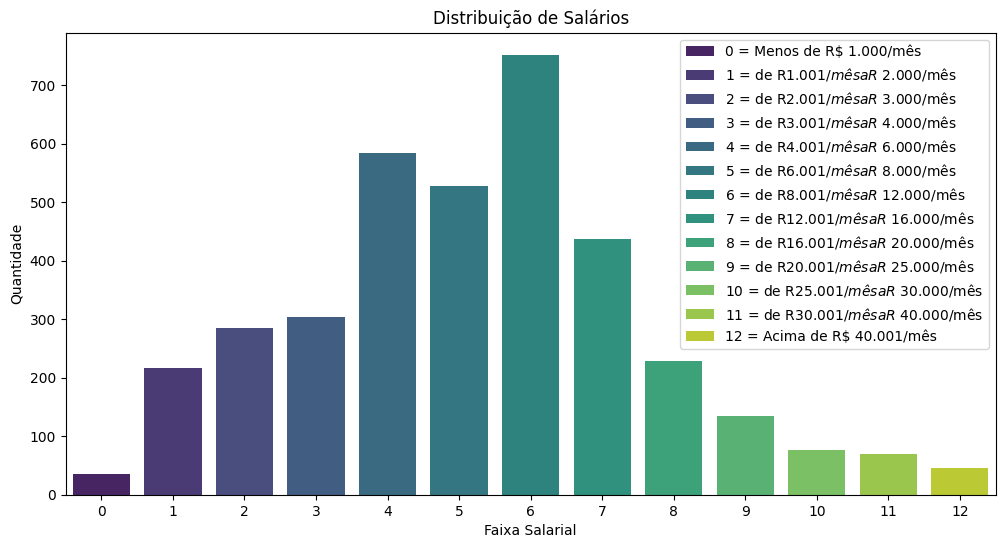

In [8]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='P2_h', palette='viridis')
plt.title('Distribuição de Salários')
plt.xlabel('Faixa Salarial')
plt.ylabel('Quantidade')
legend_labels = [f'{value} = {key}' for key, value in SALARY_MAPPING.items()]
plt.legend(legend_labels)
plt.show()

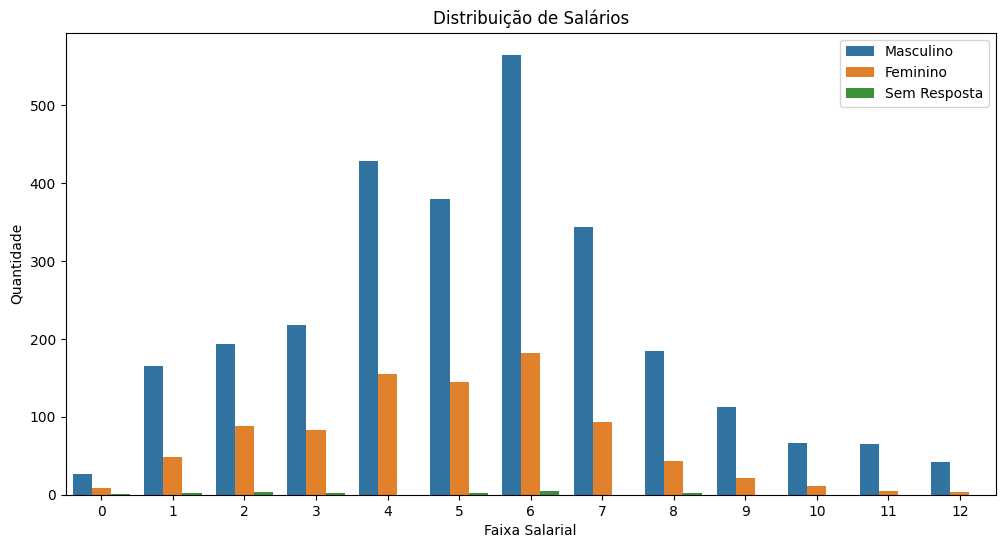

In [9]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='P2_h', hue='P1_b')
plt.title('Distribuição de Salários')
plt.xlabel('Faixa Salarial')
plt.ylabel('Quantidade')
legend_labels = df['P1_b'].unique().tolist()#[f'{value} = {key}' for key, value in SALARY_MAPPING.items()]
plt.legend(legend_labels)
plt.show()

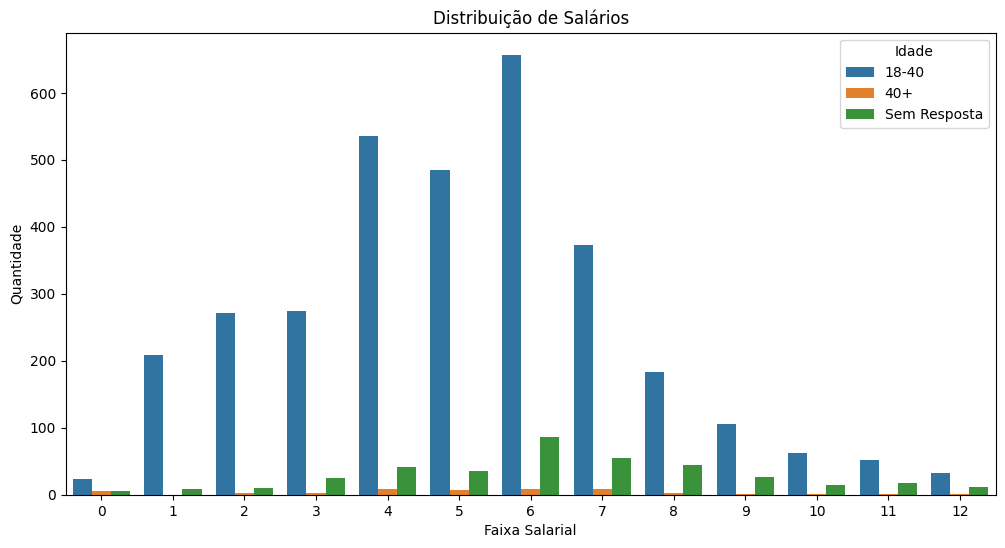

In [10]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='P2_h', hue='P1_a')
plt.title('Distribuição de Salários')
plt.xlabel('Faixa Salarial')
plt.ylabel('Quantidade')
legend_labels = df['P1_a'].unique().tolist()
plt.legend(legend_labels, title='Idade')
plt.show()

In [ ]:
# Removendo colunas que não são features
columns_to_drop = list(SENSITIVE_ATTRIBUTES.values()) + list(NOT_FEATURES.keys())   
df = df.drop(columns=columns_to_drop) 
print(f'Dataset shape after drop columns and nan target: {df.shape}')

# Salvando dataset tratado
df.to_csv('state-of-data-2022/State_of_Data_2022_cleaned.csv', index=False)
df.to_excel('state-of-data-2022/State_of_Data_2022_cleaned.xlsx', index=False)